In [1]:
# -*- coding: utf-8 -*-
import sys
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cobra
plt.rc('axes', axisbelow=True)

print('Python version:', sys.version)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('cobrapy version:', cobra.__version__)

Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.5
pandas version: 1.2.0
cobrapy version: 0.20.0
 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.5
pandas version: 1.2.0
cobrapy version: 0.20.0


In [2]:
def AddRxn(model, newRxnFile):
    """Function of adding new reactions to the model."""
    n1 = len(model.reactions)
    AllAddRxn = pd.read_csv(newRxnFile, sep=',', index_col='RxnID', skipinitialspace=True)
    n2 = len(AllAddRxn)
    for i in range(n2):
        ID = AllAddRxn.index.values[i]
        addRxn = cobra.Reaction(ID)
        model.add_reactions([addRxn])
        addRxnInf = model.reactions[n1 + i]
        addRxnInf.name = AllAddRxn.loc[ID, 'RxnName']
        addRxnInf.reaction = AllAddRxn.loc[ID, 'RxnFormula']
        addRxnInf.subsystem = AllAddRxn.loc[ID, 'Subsystem']
        addRxnInf.lower_bound = AllAddRxn.loc[ID, 'LowerBound']
        addRxnInf.upper_bound = AllAddRxn.loc[ID, 'UpperBound']
    return model

In [3]:
def flux2file(model, product, psw, output_dir='tmp'):
    """Function of exporting flux data."""
    n = len(model.reactions)
    modelMatrix = np.empty([n, 9], dtype = object)
    for i in range(len(model.reactions)):
        x = model.reactions[i]
        modelMatrix[i, 0] = i + 1
        modelMatrix[i, 1] = x.id
        modelMatrix[i, 2] = x.name
        modelMatrix[i, 3] = x.reaction
        modelMatrix[i, 4] = x.subsystem
        modelMatrix[i, 5] = x.lower_bound
        modelMatrix[i, 6] = x.upper_bound
        modelMatrix[i, 7] = x.flux
        modelMatrix[i, 8] = abs(x.flux)
        
    df = pd.DataFrame(data = modelMatrix, 
                        columns = ['N', 'RxnID', 'RxnName', 'Reaction', 'SubSystem', 
                        'LowerBound', 'UpperBound', 'Flux-core', 'abs(Flux)'])
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    filepath = os.path.join(output_dir, '{}_{}.xlsx'.format(product, psw))
    df.to_excel(filepath, index=False)

 Construct a cobora model
 The model has a constraint of producing 1 of 3pg (sink_3pg),
 set the objective to minimize ATP cost.

In [4]:
model = cobra.Model()

AddRxn(model,'CBBrxns.csv')

model.objective = {model.reactions.DM_atp: 1}
model.objective_direction = 'min'

unknown metabolite 'co2' created
unknown metabolite 'h2o' created
unknown metabolite 'rb15bp' created
unknown metabolite '3pg' created
unknown metabolite 'h' created
unknown metabolite 'o2' created
unknown metabolite 'h2o' created
unknown metabolite 'rb15bp' created
unknown metabolite '3pg' created
unknown metabolite 'h' created
unknown metabolite 'o2' created
unknown metabolite '2pglyc' created
unknown metabolite 'atp' created
unknown metabolite '13dpg' created
unknown metabolite 'adp' created
unknown metabolite 'nadph' created
unknown metabolite 'g3p' created
unknown metabolite 'nadp' created
unknown metabolite 'pi' created
unknown metabolite 'dhap' created
unknown metabolite 'fdp' created
unknown metabolite 'f6p' created
unknown metabolite 'e4p' created
unknown metabolite 'xu5p' created
unknown metabolite 's17bp' created
unknown metabolite 's7p' created
unknown metabolite 'r5p' created
unknown metabolite 'ru5p' created
unknown metabolite 'amp' created
unknown metabolite 'nad' create

 Set the carboxylation and oxygenation reaction ratio
 of RuBisCO to be 3:1

In [5]:
rubisco_flux = model.problem.Constraint(
    model.reactions.RBPC.flux_expression - 3 * model.reactions.RBPO.flux_expression,
    lb = 0, 
    ub = 0
)
model.add_cons_vars(rubisco_flux)

 Routes to compare (see [Scheffen et al 2021 Nat Catal](https://doi.org/10.1038/s41929-020-00557-y),
 [Trudeau et al 2018 PNAS](https://doi.org/10.1073/pnas.1812605115) & this study):
 - Natural photorespiration (NPR)
 - Glycerate route (GLC)
 - GLycolate oxidation pathway (OX)
 - Arabinose 5-phosphate shunt (A5P)
 - Tartronyl-CoA pathway (TACO)
 - CORE with an acetoacetyl-CoA synthetase (CORE_Lig)
 - CORE with an formate-acetoacetate CoA-transferase (CORE_CoAT)

In [6]:
photores = {
    'NPR': 'a_NPRrxns.csv',    # natural photorespiration
    'GLC': 'b_GLCrxns.csv',    # glycerate bypass
    'OX': 'c_OXrxns.csv',      # glycolate oxidation pathway
    'A5P': 'd_A5Prxns.csv',    # arabinose-5-phosphate shunt
    '3OHP': 'e_3OHPrxns.csv',  # 3-hydroxypropionate bypass
    'TACO': 'f_TACOrxns.csv',  # tartronyl-CoA pathway
    'CORE_Lig': 'x1_CORE_Lig_rxns.csv',
    'CORE_CoAT': 'x2_CORE_CoAT_rxns.csv',
}

cost_df = pd.DataFrame()

In [7]:
for psw, rxns in photores.items():
    with model as m:
        AddRxn(m, rxns)
        m.optimize()
        flux2file(m,'3pg',psw,'output')
        for cost in ['DM_atp', 'DM_e', 'Fdr', 'EX_co2', 'RBPC', 'RBPO', 'sink_3pg']:
            cost_df.loc[cost, psw] = abs(m.reactions.get_by_id(cost).flux)

unknown metabolite 'glyclt' created
unknown metabolite 'glx' created
unknown metabolite 'h2o2' created

unknown metabolite 'glx' created
unknown metabolite 'h2o2' created
unknown metabolite 'ser' created
unknown metabolite 'gly' created
unknown metabolite 'hpyr' created
unknown metabolite 'glu' created
unknown metabolite 'akg' created
unknown metabolite 'gln' created
unknown metabolite 'mlthf' created
unknown metabolite 'thf' created
unknown metabolite 'glyc' created
unknown metabolite 'glyclt' created
unknown metabolite 'glx' created
unknown metabolite 'h2o2' created
unknown metabolite '2h3oppan' created
unknown metabolite 'glyc' created
unknown metabolite 'glyclt' created
unknown metabolite 'glx' created
unknown metabolite 'h2o2' created
unknown metabolite 'accoa' created
unknown metabolite 'mal' created
unknown metabolite 'coa' created
unknown metabolite 'pyr' created
unknown metabolite 'glyclt' created
unknown metabolite 'coa' created
unknown metabolite 'glyccoa' created
unknown me

 Use the GCC M5 variant that hydrolyse 3.9 ATP per carboxylation
 (Fig. 2c of [TACO](https://doi.org/10.1038/s41929-020-00557-y))

In [8]:
with model as m:
    AddRxn(m, 'f_TACOrxns.csv')
    m.reactions.GCC.add_metabolites({'atp': -2.9, 'adp': 2.9, 'pi': 2.9})
    print(m.reactions.GCC)
    m.optimize()
    flux2file(m,'3pg', 'TACO_M5','output')
    for cost in ['DM_atp', 'DM_e', 'Fdr', 'EX_co2', 'RBPC', 'RBPO', 'sink_3pg']:
        cost_df.loc[cost, 'TACO_M5'] = abs(m.reactions.get_by_id(cost).flux)

unknown metabolite 'glyclt' created
unknown metabolite 'coa' created
unknown metabolite 'glyccoa' created
unknown metabolite 'tarcoa' created
unknown metabolite 'coa' created
unknown metabolite 'glyccoa' created
unknown metabolite 'tarcoa' created
unknown metabolite '2h3oppan' created
unknown metabolite 'glyc' created
GCC: 3.9 atp + glyccoa + hco3 --> 3.9 adp + 3.9 pi + tarcoa


 Use the GCC M5 L100N variant that hydrolyse 1.7 ATP per carboxylation
 ([Marchal et al 2023 ACS Synth Biol](https://doi.org/10.1021/acssynbio.3c00403))

In [9]:
with model as m:
    AddRxn(m, 'f_TACOrxns.csv')
    m.reactions.GCC.add_metabolites({'atp': -0.7, 'adp': 0.7, 'pi': 0.7})
    print(m.reactions.GCC)
    m.optimize()
    flux2file(m,'3pg', 'TACO_L100N','output')
    for cost in ['DM_atp', 'DM_e', 'Fdr', 'EX_co2', 'RBPC', 'RBPO', 'sink_3pg']:
        cost_df.loc[cost, 'TACO_L100N'] = abs(m.reactions.get_by_id(cost).flux)

unknown metabolite 'glyclt' created
unknown metabolite 'coa' created
unknown metabolite 'glyccoa' created
unknown metabolite 'tarcoa' created
unknown metabolite 'coa' created
unknown metabolite 'glyccoa' created
unknown metabolite 'tarcoa' created
unknown metabolite '2h3oppan' created
unknown metabolite 'glyc' created
GCC: 1.7 atp + glyccoa + hco3 --> 1.7 adp + 1.7 pi + tarcoa


In [10]:
cost_df

,NPR,GLC,OX,A5P,3OHP,TACO,CORE_Lig,CORE_CoAT,TACO_M5,TACO_L100N
DM_atp,14.0,13.4,32.0,12.0,11.75,11.00,11.75,10.25,13.175,11.525
DM_e,8.0,8.6,14.0,7.0,6.50,6.50,7.25,7.25,6.500,6.500
Fdr,1.2,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000,0.000
EX_co2,3.0,3.0,3.0,3.0,3.00,3.00,3.00,3.00,3.000,3.000
RBPC,3.6,3.6,9.0,3.0,2.25,2.25,2.25,2.25,2.250,2.250
RBPO,1.2,1.2,3.0,1.0,0.75,0.75,0.75,0.75,0.750,0.750
sink_3pg,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.000,1.000


 Assuming 1 NAD(P)H = 2 ferredoxin,
 and along ETC: 1 NAD(P)H = 2.5 ATP

In [11]:
cost_df.loc['reducing_eq',:]=cost_df.loc['DM_atp',:]/2.5 + cost_df.loc['DM_e'] + cost_df.loc['Fdr']/2
cost_df.loc['Yield',:]=1/cost_df.loc['reducing_eq',:]  # per reducing equivalent  
cost_df.loc['Rel_yield',:]=cost_df.loc['Yield',:]/cost_df.loc['Yield','NPR']*100
cost_df.to_excel('CORE costs comparison.xlsx')
cost_df.round(3)

,NPR,GLC,OX,A5P,3OHP,TACO,CORE_Lig,CORE_CoAT,TACO_M5,TACO_L100N
DM_atp,14.00,13.400,32.000,12.000,11.750,11.000,11.750,10.250,13.175,11.525
DM_e,8.00,8.600,14.000,7.000,6.500,6.500,7.250,7.250,6.500,6.500
Fdr,1.20,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
EX_co2,3.00,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000
RBPC,3.60,3.600,9.000,3.000,2.250,2.250,2.250,2.250,2.250,2.250
RBPO,1.20,1.200,3.000,1.000,0.750,0.750,0.750,0.750,0.750,0.750
sink_3pg,1.00,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
reducing_eq,14.20,13.960,26.800,11.800,11.200,10.900,11.950,11.350,11.770,11.110
Yield,0.07,0.072,0.037,0.085,0.089,0.092,0.084,0.088,0.085,0.090
Rel_yield,100.00,101.719,52.985,120.339,126.786,130.275,118.828,125.110,120.646,127.813


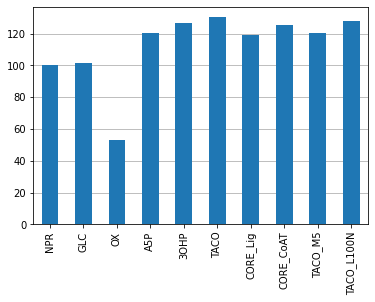

In [12]:
fig, ax = plt.subplots()
cost_df.loc['Rel_yield'].plot(kind='bar', ax=ax)
ax.grid(axis='y')
plt.savefig('CORE cost comparison.eps',dpi=300,format='pdf')
plt.show()